# ECG心拍データを1次元CNNで解析する
参考→
https://www.kaggle.com/coni57/model-from-arxiv-1805-00794/notebook

# ドライブのマウント

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TensorFlow・kerasのインストール

In [113]:
# !pip uninstall -y tensorflow
# !pip install tensorflow==1.15

In [114]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [115]:
!pip install keras==2.2.4

## ライブラリのインストール

In [116]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import math
import random
import pickle
import itertools

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle
from sklearn.preprocessing import OneHotEncoder

import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/My Drive/かがわAIゼミナール_最終課題/suai_finaltask/data"))

# Any results you write to the current directory are saved as output.

['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']


## データの整理・確認

In [117]:
df_train = pd.read_csv("/content/drive/My Drive/かがわAIゼミナール_最終課題/suai_finaltask/data/mitbih_train.csv", header=None)
df_test = pd.read_csv("/content/drive/My Drive/かがわAIゼミナール_最終課題/suai_finaltask/data/mitbih_test.csv", header=None)

trainデータとtestデータを一旦結合する。

In [118]:
df = pd.concat([df_train, df_test], axis=0)

データの中身を調べる。

In [119]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


簡単に表すと下記のようなデータ構造。  
・0列目～186列目：心拍データ  
・187列目：ラベル

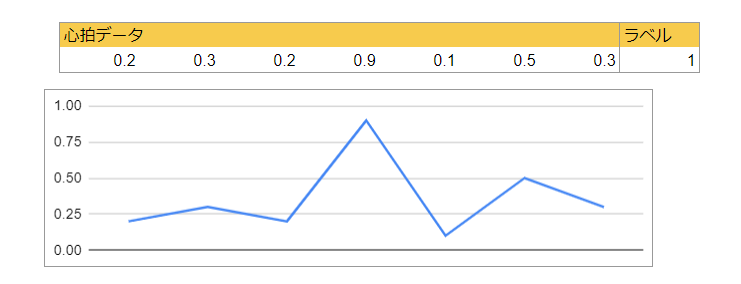

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


187列目が不整脈のクラス（Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]）を示しているので、その割合を調べる。

In [121]:
df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

最終列を除くデータをX、最終列（不整脈クラス）をyとして定義する。

In [122]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

Xとyの配列の構造を確かめる。  
・Xは縦がデータ数、横がデータの長さ  
・yは横方向にデータ数が並べられている

In [123]:
print(X.shape)
print(y.shape)

(109446, 187)
(109446,)


dfがXとyに分かれて不要になったため削除する。

In [124]:
del df
del M

## データの可視化

不整脈クラスごとに分類してインデックスを返す

例）C0はyの値が0になっている行の番号を返している。

※flatten関数は配列データを平坦にする

In [125]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

こういうこと↓

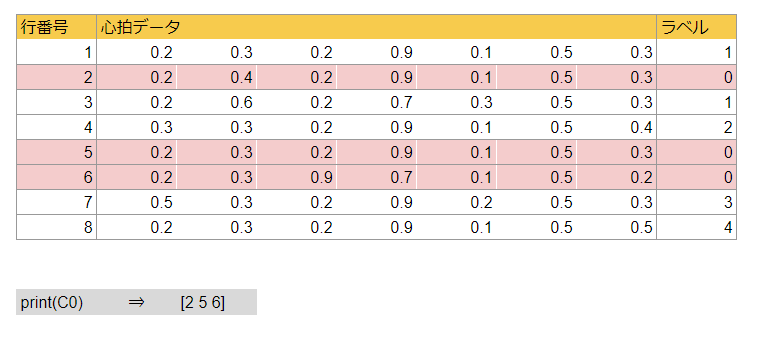

各カテゴリーの1個目のデータだけをplotする

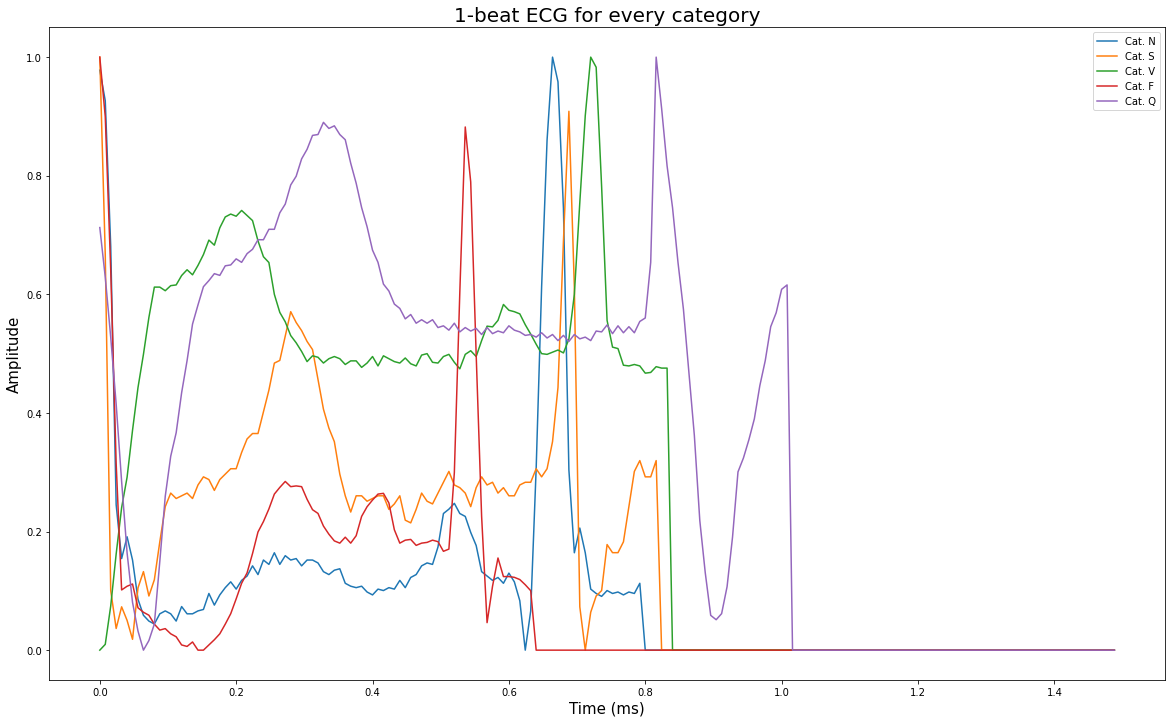

In [126]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

# データ拡張  
  
0.0    90589  
1.0     2779  
2.0     7236   
3.0      803  
4.0     8039 

ラベルが3となる行の値の数が少なく、学習に支障をきたすため3をデータ拡張する。

▼データをダウンサンプリングする関数  
参考：https://insilico-notebook.com/spectrum-resampling/#

In [127]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

▼波形の値を0.0以上1.0未満の範囲で大きくしたり小さくしたりする関数

In [128]:
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

関数を通した結果を描画すると下記になる。

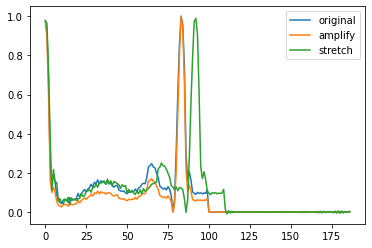

In [129]:
plt.plot(X[0, :], label="original")
plt.plot(amplify(X[0, :]), label="amplify")
plt.plot(stretch(X[0, :]), label="stretch")
plt.legend()
plt.show()

▼ランダムでデータ拡張手法を選んで拡張してくれる関数  
・stretch  
・amplify  
・stretchしてからamplify  
を3分の1ずつの確率で実行  
  
<font color="red">※参考サイトではresult = np.zeros(shape= (4, 187))となっていたところを  
result = np.zeros(shape= (3, 187))に変更しました。  
∵4行目がいつも0のみになってしまうから</font>

In [130]:
def augment(x):
    result = np.zeros(shape= (3, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

C3に対してデータ拡張をかける。

In [131]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classe = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classe])

In [132]:
print("C0", np.count_nonzero(y==0))
print("C1", np.count_nonzero(y==1))
print("C2", np.count_nonzero(y==2))
print("C3", np.count_nonzero(y==3))
print("C4", np.count_nonzero(y==4))

C0 90589
C1 2779
C2 7236
C3 3212
C4 8039


# ホールドアウト法に用いる検証用データを用意する

各ラベルから800データずつ抽出する。

In [133]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

subC0～subC4を検証用データとし、残りを学習用データとする。

[[9]](https://colab.research.google.com/drive/13MSO2d7XDM6D1j0Myg069y5XfLrwOzPe#scrollTo=hB8gwxiiLKGZ&line=1&uniqifier=1)より、  
Xは縦方向がデータ数、横方向がデータの長さとなっているため、vstackを、  
yは横方向にデータ数となっているためhstackを
それぞれ使用してデータを追加する。

In [134]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

1次元CNNにかけられるよう、心拍データを3次元配列にする。  
心拍データを3次元配列<font color="red">(バッチサイズ,時系列データの長さ,各データのベクトル)</font>にする。 

In [135]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (108347, 187)
y_train (108347,)
X_test (4000, 187)
y_test (4000,)


In [136]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [137]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (108347, 187, 1)
y_train (108347,)
X_test (4000, 187, 1)
y_test (4000,)


分類データをワンホットベクトルにする。

In [138]:
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [139]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (108347, 187, 1)
y_train (108347, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


# 1次元CNN
参考→https://www.tcom242242.net/entry/ai-2/deeplearning/1dcnntensorflow2-conv1d/

In [140]:
n_obs, feature, depth = X_train.shape
batch_size = 500
print("n_obs =",n_obs)
print("feature =",feature)
print("depth =",depth)

n_obs = 108347
feature = 187
depth = 1


つまり、データ1件につき長さ187のデータを1本持つ。

In [141]:
# 現在のTFグラフを壊し，新たなものを作成します
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

学習率を定める。  
参考：[LearningRateScheduler｜Keras公式ドキュメント](https://keras.io/api/callbacks/learning_rate_scheduler/)  
<font color="red">※工夫の余地あり※</font>

In [142]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

勾配法の最適化手法にAdamを採用

In [143]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

モデルをコンパイルする。

In [144]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

モデルを学習させる。  
<font color="red">※時間節約のためepoch数を75から10に減らしている。（あとで戻す）</font>

In [145]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=batch_size, 
                    verbose=2, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate])

Train on 108347 samples, validate on 4000 samples
Epoch 1/10
 - 113s - loss: 0.3835 - acc: 0.8851 - val_loss: 0.7737 - val_acc: 0.7845
Epoch 2/10
 - 99s - loss: 0.1351 - acc: 0.9638 - val_loss: 0.6423 - val_acc: 0.8360
Epoch 3/10
 - 97s - loss: 0.0988 - acc: 0.9730 - val_loss: 0.4322 - val_acc: 0.8785
Epoch 4/10
 - 97s - loss: 0.0843 - acc: 0.9764 - val_loss: 0.5447 - val_acc: 0.8577
Epoch 5/10
 - 96s - loss: 0.0750 - acc: 0.9787 - val_loss: 0.5710 - val_acc: 0.8455
Epoch 6/10
 - 96s - loss: 0.0681 - acc: 0.9804 - val_loss: 0.4069 - val_acc: 0.8865
Epoch 7/10
 - 96s - loss: 0.0622 - acc: 0.9816 - val_loss: 0.3510 - val_acc: 0.8978
Epoch 8/10
 - 96s - loss: 0.0577 - acc: 0.9826 - val_loss: 0.4003 - val_acc: 0.8795
Epoch 9/10
 - 96s - loss: 0.0524 - acc: 0.9838 - val_loss: 0.2862 - val_acc: 0.9122
Epoch 10/10
 - 96s - loss: 0.0507 - acc: 0.9844 - val_loss: 0.3057 - val_acc: 0.9075


In [146]:
y_pred = model.predict(X_test, batch_size=1000)

In [147]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84       800
           1       0.98      0.76      0.86       800
           2       0.95      0.94      0.95       800
           3       0.98      0.85      0.91       800
           4       1.00      0.98      0.99       800

    accuracy                           0.91      4000
   macro avg       0.93      0.91      0.91      4000
weighted avg       0.93      0.91      0.91      4000



学習結果を見る。

In [148]:
print("ranking-based average precision : {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Ranking loss : {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverage_error : {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


ranking-based average precision : 0.951
Ranking loss : 0.028
Coverage_error : 1.113


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Confusion matrix, without normalization


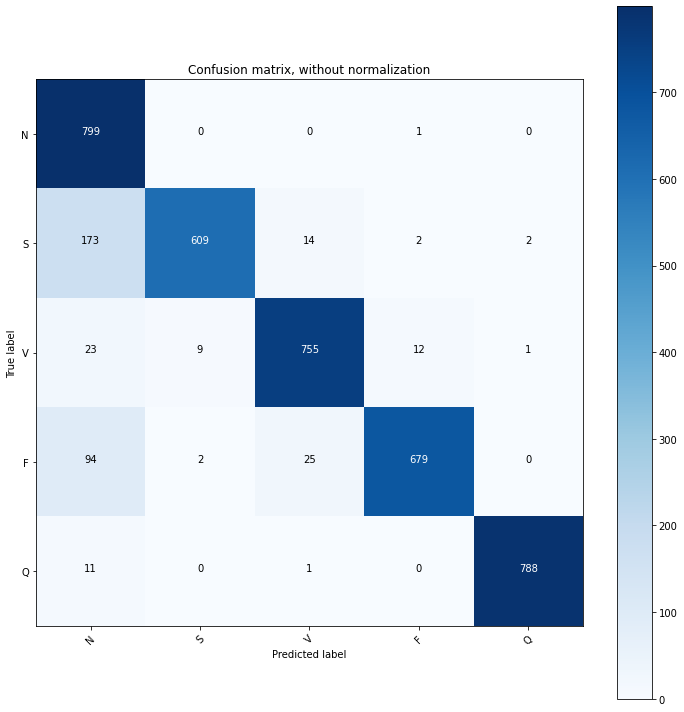

In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()